# Analysis of HD32313 data

In [1]:
import os
import copy
import wget
import time
import asyncio
import warnings
import logging

import numpy as np
import pandas as pd
from pathlib import Path

from astropy.io import fits
from astropy.modeling import models, fitting

from scipy import ndimage
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter

from matplotlib import pyplot as plt

from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.Utility import DefocalType, CamType

plt.rcParams['figure.figsize'] = [7, 6]

%matplotlib inline

In [ ]:
from lsst.ts.wep.Utility import getConfigDir

In [ ]:
getConfigDir()

In [62]:
class DonutHandler:
    def __init__(self):
        
        self.data_folder = Path("data/")
        self.output_folder = Path("data/output")

        self.intra_fnames = []
        self.extra_fnames = []
        
        self.intra_exposures = []
        self.extra_exposures = []
        
        self.dz = []
        self.dz_dict = {}

        # I1/I2 get modified down below, so reset here
        self.I1 = []
        self.I2 = []
        self.pMask = []
        self.to_process = []

        self.zern = []

        # Select where your object is, but ours will be on-axis
        self.fieldXY = [0.0,0.0]

        self.ceny = 350 #round(im_shape[0]/2)
        self.cenx = 450 # round(im_shape[1]/2)
        
        self.pre_side = 300
        self.side = 192  # size for dz=1.5
        
    @property
    def ndata(self):
        return len(self.intra_fnames)
    
    def set_intra_extra(self, intra, extra):
        
        self.intra_fnames = intra
        self.extra_fnames = extra
        
        for i in range(self.ndata):
            self.intra_exposures.append((fits.open(self.data_folder / intra[i]))[0].data)
            self.extra_exposures.append((fits.open(self.data_folder / extra[i]))[0].data)
    
    def set_dz(self, dz_list):
        
        if len(dz_list) != self.ndata:
            raise RuntimeError("dzlist and ndata must have size lenght.")
        
        self.dz = np.copy(dz_list)
        cwfs_config_template = """
obscuration: 0.3525
focalLength: 21.6
apertureDiameter: 1.2
offset:
offset:
  0.02050mm: 0.0205
  0.50000mm: 0.5e-3
  1.00000mm: 1.0e-3
  1.50000mm: 1.5e-3
  2.00000mm: 2.0e-3
  2.50000mm: 2.50e-3
pixelSize: 1.44e-5
"""
        unique_dz = np.unique(self.dz)
        
        data_path = "data/"
        instrument = "latiss"
        for i in range(len(unique_dz)):
            config_index = f"latiss"
            path = Path(f"{data_path}/{instrument}/")
            if not path.exists():
                os.makedirs(path)
            config_file = f"latiss_{i}.param"
            dest = path.joinpath(config_file)
            with open(dest, "w") as fp:
                fp.write(cwfs_config_template.format(unique_dz[i]*0.041))
            self.dz_dict[unique_dz[i]] = data_path, instrument, config_file

    def center_and_cut_image(self, index, side=400, semi_auto=False, manual=False):
        
        intra_exp = self.intra_exposures[index]
        extra_exp = self.extra_exposures[index]

        if not manual:
            
            if semi_auto:
                ceny, cenx = self.ceny, self.cenx
                print(ceny, cenx)                
            else:
                print("Automatic centering")
                im_shape=intra_exp.shape
                im_filtered = medfilt(intra_exp+extra_exp,[3,3])
                im_filtered -= int(np.median(im_filtered))
                mean = np.mean(im_filtered)
                # iter 1
                ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
                print(ceny, cenx)
            # iter 2
            intra_square = intra_exp[ceny-self.pre_side:ceny+self.pre_side, 
                                     cenx-self.pre_side:cenx+self.pre_side] 
            extra_square = extra_exp[ceny-self.pre_side:ceny+self.pre_side, 
                                     cenx-self.pre_side:cenx+self.pre_side]
            print(intra_square.shape, extra_square.shape)
            im = (intra_square+extra_square)
            im_filtered = medfilt(im,[3,3])
            im_filtered -= int(np.median(im_filtered))
            mean = np.mean(im_filtered)
            im_filtered[im_filtered < mean] = 0.
            im_filtered[im_filtered > mean] = 1.
            # iter 1
            cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
            print(cy2-self.pre_side, cx2-self.pre_side)    
            ceny += (cy2-self.pre_side)
            cenx += (cx2-self.pre_side)
            
            # Now center individually 
            ## INTRA
            intra_square_2 = intra_exp[ceny-self.pre_side:ceny+self.pre_side, 
                                       cenx-self.pre_side:cenx+self.pre_side] 

            
            intra_filtered = medfilt(intra_square_2,[3,3])
            intra_filtered -= int(np.median(intra_filtered))

            mean = np.mean(intra_filtered)
            intra_filtered[intra_filtered < mean] = 0.
            intra_filtered[intra_filtered > mean] = 1.
            # iter 1
            cy2_intra, cx2_intra = np.array(ndimage.measurements.center_of_mass(intra_filtered), dtype=int)
            print(cy2_intra-self.pre_side, cx2_intra-self.pre_side)    
            ceny_intra = ceny+(cy2_intra-self.pre_side)
            cenx_intra = cenx+(cx2_intra-self.pre_side)
            
            ## EXTRA
            extra_square_2 = extra_exp[ceny-self.pre_side:ceny+self.pre_side, 
                                       cenx-self.pre_side:cenx+self.pre_side] 

            
            extra_filtered = medfilt(extra_square_2,[3,3])
            extra_filtered -= int(np.median(extra_filtered))

            mean = np.mean(extra_filtered)
            intra_filtered[extra_filtered < mean] = 0.
            intra_filtered[extra_filtered > mean] = 1.
            # iter 1
            cy2_extra, cx2_extra = np.array(ndimage.measurements.center_of_mass(extra_filtered), dtype=int)
            print(cy2_extra-self.pre_side, cx2_extra-self.pre_side)    
            ceny_extra = ceny+(cy2_extra-self.pre_side)
            cenx_extra = cenx+(cx2_extra-self.pre_side)
        else:
            print("Manual centering")
            ceny_intra=self.ceny #round(im_shape[0]/2)
            cenx_intra=self.cenx # round(im_shape[1]/2)
            
            ceny_extra=self.ceny #round(im_shape[0]/2)
            cenx_extra=self.cenx # round(im_shape[1]/2)
            
        side=int(self.side*self.dz[index]/1.5) # side length of image
        print(f"Side is {side}")
        print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
        im_shape=intra_exp.shape
        intra_square = intra_exp[ceny_intra-side:ceny_intra+side, cenx_intra-side:cenx_intra+side] 
        extra_square = extra_exp[ceny_extra-side:ceny_extra+side, cenx_extra-side:cenx_extra+side]

        return intra_square, extra_square
    
    def create_images(self):
        
        for i in range(self.ndata):
            try:
                i1, i2 = self.center_and_cut_image(i)
            except Exception as e:
                print(f"Could not process pair {i}: {self.intra_fnames[i]} x {self.extra_fnames[i]}. Consider removing from data")
                self.to_process.append(False)
                self.I1.append(None)
                self.I2.append(None)
            else:
                self.to_process.append(True)
                self.I1.append(CompensableImage())
                self.I1[-1].setImg(fieldXY=self.fieldXY, 
                                   defocalType=DefocalType.Intra, 
                                   image=i1)
                self.I2.append(CompensableImage())
                self.I2[-1].setImg(fieldXY=self.fieldXY,
                                   defocalType=DefocalType.Intra,
                                   image=i2)

    def run_algo(self):
        # Declare instrument
        
        #declare algorithm
        # declare algorithm - exponential solver.
        
        for i in range(self.ndata):
            if not self.to_process[i]:
                print(f"Skiping pair {i}")
                self.zern.append(np.zeros(9))
                self.pMask.append(None)
                continue

            dz = self.dz[i]
            
            hex_to_focus_scale = 41.0
            offset=1.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
            pixelsize = 3.6e-6*4 # 4 is the binning
            # FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

            print(f"dz:{dz} - {self.dz_dict[dz]}")
            inst = Instrument(self.dz_dict[dz][0])
            
            inst.config(CamType.Latiss, 
                        self.I1[i].getImgSizeInPix(), 
                        announcedDefocalDisInMm=dz*0.041,
                        instParamFileName=self.dz_dict[dz][2])

#             print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
#             print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
#             print('pixelSize should be: {}'.format(pixelsize))

            algo = Algorithm(Path(self.dz_dict[dz][0])) # example     
            
            algo.config("exp", inst, 1)

#             algo.reset(donut_handler.I1[i], donut_handler.I2[i])

            algo.runIt(self.I1[i],self.I2[i],'onAxis',tol=1e-6)
            
            self.pMask.append(algo.pMask)
            
            self.zern.append(algo.zer4UpNm[0:9])


## Dataset 1:

El: ??. -- about ??:?? UTC

Extra-focal filename: 1576286733-HD32313-0-1.fits

Intra-focal filename: 1576286665-HD32313-0-1.fits

In [3]:
intra_fname_1 = "1579919938-HD32309_intra-0-1.fits"
extra_fname_1 = "1579919976-HD32309_extra-0-1.fits"

In [4]:
intra_fname_2 = "1576287165-HD32313-0-1.fits"
extra_fname_2 = "1576287233-HD32313-0-1.fits"

In [5]:
intra_fnames = [intra_fname_1]
extra_fnames = [extra_fname_1]

In [63]:
donut_handler = DonutHandler()

In [64]:
donut_handler.set_intra_extra(intra_fnames, extra_fnames)

In [65]:
donut_handler.set_dz([0.5])

In [66]:
donut_handler.create_images()

Automatic centering
426 491
(600, 600) (600, 600)
4 6
-2 -1
4 2
Side is 64
Creating stamps of centroid [y,x] = [430,497] with a side length of 64 pixels


In [67]:
%time donut_handler.run_algo()

dz:0.5 - ('data/', 'latiss', 'latiss_0.param')
data/exp.yaml
0.0005694444444444444 1.2 21.6 0.0205 1
0.0005694444444444444 1.2 21.6 0.0205 1
CPU times: user 14 s, sys: 14.9 ms, total: 14 s
Wall time: 14 s


In [ ]:
"%.05fmm" % (0.5*0.041)

In [68]:
donut_handler.zern

[array([ 5.18294174e+01, -5.24709047e+02,  4.25560662e+01,  6.62196990e+01,
         5.14056808e+01, -8.25070188e+01,  4.67873051e+01,  9.27620253e-02,
         5.32913652e+00])]

In [ ]:
fig = plt.figure()

for i in range(donut_handler.ndata):
    sub = fig.add_subplot(1, donut_handler.ndata, 1+i)
    sub.imshow(donut_handler.intra_exposures[i]+donut_handler.extra_exposures[i])

In [ ]:
donut_handler.I1[i].getPaddedMask()

In [ ]:
donut_handler.create_images()

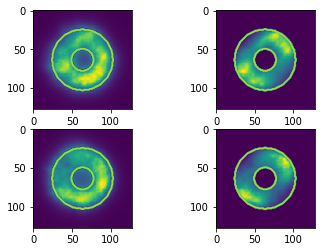

In [69]:
fig = plt.figure()

for i in range(donut_handler.ndata):
    sub1 = fig.add_subplot(2, donut_handler.ndata*2, 1+i)
    sub1.imshow(donut_handler.I1[i].getImgInit())
    sub1.contour(donut_handler.I1[i].getPaddedMask())

    sub2 = fig.add_subplot(2, donut_handler.ndata*2, 1+i+1)
    sub2.imshow(donut_handler.I1[i].getImg())
    sub2.contour(donut_handler.I1[i].getPaddedMask())


    sub3 = fig.add_subplot(2, donut_handler.ndata*2, donut_handler.ndata*2+1+i)
    sub3.imshow(donut_handler.I2[i].getImgInit())
    sub3.contour(donut_handler.I2[i].getPaddedMask())

    sub4 = fig.add_subplot(2, donut_handler.ndata*2, donut_handler.ndata*2+1+i+1)
    sub4.imshow(donut_handler.I2[i].getImg())
    sub4.contour(donut_handler.I2[i].getPaddedMask())



In [ ]:
donut_handler.run_algo()

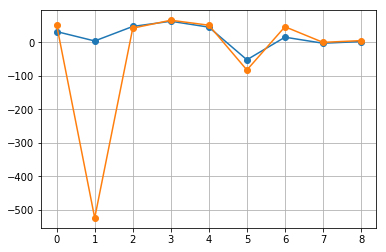

In [71]:
plt.plot([ 32.2645941,4.29266578,47.65209892,63.18508016,45.57920344,-51.99155162,15.53372854,-2.4934468,2.51359808], 'o-')

for i in range(donut_handler.ndata):
    plt.plot(donut_handler.zern[i], 'o-')
plt.grid()

In [ ]:
# Plot images with masks to check mapping is correct
# I think these plot residuals, but I1.image0 plots the original image
# plots.plotImage(donut_handler.I1[3].image0,'intra', mask=algo.pMask) 
plots.plotImage(donut_handler.I1[0].image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(donut_handler.I2[0].image,'extra', mask=algo.pMask)

In [ ]:
df = pd.DataFrame.from_csv("20200124_match_test1.csv")

In [ ]:
df

In [ ]:
df['dz']

In [ ]:
donut_handler = DonutHandler()

In [ ]:
donut_handler.set_intra_extra(df['intra'], df['extra'])

In [ ]:
donut_handler.set_dz(df['dz'])

In [ ]:
donut_handler.create_images()

In [ ]:
donut_handler.run_algo()

In [ ]:
x = np.arange(9)+4
for i in range(len(donut_handler.zern)):
    plt.plot(x, donut_handler.zern[i], 'o-', label=f'{donut_handler.dz[i]}')

plt.ylabel("Zernike coeff (nm)")
plt.xlabel("Zernike index")
plt.grid()
plt.legend()

In [ ]:
x = np.arange(9)+4

plt.plot(x, donut_handler.zern[0], 'o-', label=f'{donut_handler.dz[0]}')
plt.plot(x, donut_handler.zern[1], 'o-', label=f'{donut_handler.dz[1]}')

xlim = plt.xlim()

plt.plot(np.arange(15), np.zeros(15)+50, 'b--')
plt.plot(np.arange(15), np.zeros(15)-50, 'b--')
plt.xlim(xlim)
plt.ylabel("Zernike coeff (nm)")
plt.xlabel("Zernike index")
plt.grid()
plt.legend()

In [ ]:
fig1 = plt.figure(1, figsize=(12,8))

ax11 = fig1.add_subplot(221)

ax11.set_title("defocus 0.5 - intra")
ax11.imshow(donut_handler.I1[0].image0)
ax11.contour(donut_handler.pMask[0]) 

ax12 = fig1.add_subplot(223)

ax12.set_title("defocus 0.5 - extra")
ax12.imshow(donut_handler.I2[0].image0)
ax12.contour(donut_handler.pMask[0]) 

ax21 = fig1.add_subplot(222)

ax21.set_title("defocus 1.5 - intra")
ax21.imshow(donut_handler.I1[1].image0)
ax21.contour(donut_handler.pMask[1]) 

ax22 = fig1.add_subplot(224)

ax22.set_title("defocus 1.5 - extra")
ax22.imshow(donut_handler.I2[1].image0)
ax22.contour(donut_handler.pMask[1]) 




In [ ]:
x = np.arange(9)+4
for i in range(len(donut_handler.zern)):
    plt.plot(x, donut_handler.zern[i], 'o-', label=f'{donut_handler.dz[i]}')

plt.ylabel("Zernike coeff (nm)")
plt.xlabel("Zernike index")
plt.grid()
plt.legend()

In [ ]:
fig1 = plt.figure(1, figsize=(12,8))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler.I1[0].image0)
ax11.contour(donut_handler.pMask[0]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler.I2[0].image0)
ax12.contour(donut_handler.pMask[0]) 


In [ ]:
fig1 = plt.figure(1, figsize=(12,8))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler.I1[1].image0)
ax11.contour(donut_handler.pMask[1]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler.I2[1].image0)
ax12.contour(donut_handler.pMask[1]) 



In [ ]:
df2 = pd.DataFrame.from_csv("20200124_match_test2.csv")

In [ ]:
donut_handler2 = DonutHandler()

In [ ]:
donut_handler2.set_intra_extra(df2['intra'], df2['extra'])

In [ ]:
donut_handler2.set_dz(df2['dz'])

In [ ]:
donut_handler2.create_images()

In [ ]:
donut_handler2.run_algo()

In [ ]:
x = np.arange(9)+4
for i in range(len(donut_handler2.zern)):
    plt.plot(x, donut_handler2.zern[i], 'o-', label=f'{donut_handler2.dz[i]}')

plt.ylabel("Zernike coeff (nm)")
plt.xlabel("Zernike index")
plt.grid()
plt.legend()

In [ ]:

fig1 = plt.figure(1, figsize=(12,8))

ax11 = fig1.add_subplot(121)

plots.plotImage(donut_handler2.I1[0].image,'intra', mask=donut_handler2.pMask[0], show=False)

ax23 = fig1.add_subplot(122)

plots.plotImage(donut_handler2.I2[0].image,'extra', mask=donut_handler2.pMask[0], show=False) 


In [ ]:
fig1 = plt.figure(1, figsize=(12,8))

ax11 = fig1.add_subplot(121)

plots.plotImage(donut_handler2.I1[1].image,'intra', mask=donut_handler2.pMask[1], show=False)

ax23 = fig1.add_subplot(122)

plots.plotImage(donut_handler2.I2[1].image,'extra', mask=donut_handler2.pMask[1], show=False) 


In [ ]:

fig1 = plt.figure(1, figsize=(12,8))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler2.I1[0].image)

# ax23 = fig1.add_subplot(122)

ax11.contour(donut_handler2.pMask[0]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler2.I2[0].image)

# ax23 = fig1.add_subplot(122)

ax12.contour(donut_handler2.pMask[0]) 




In [ ]:

fig1 = plt.figure(1, figsize=(12,8))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler2.I1[1].image)

# ax23 = fig1.add_subplot(122)

ax11.contour(donut_handler2.pMask[1]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler2.I2[1].image)

# ax23 = fig1.add_subplot(122)

ax12.contour(donut_handler2.pMask[1]) 





In [ ]:

fig1 = plt.figure(1, figsize=(12,8))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler2.I1[2].image)

# ax23 = fig1.add_subplot(122)

ax11.contour(donut_handler2.pMask[2]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler2.I2[2].image)

# ax23 = fig1.add_subplot(122)

ax12.contour(donut_handler2.pMask[2]) 


In [ ]:
df3 = pd.DataFrame.from_csv("20200124_match_test3.csv")

In [ ]:
donut_handler3 = DonutHandler()

In [ ]:
donut_handler3.set_intra_extra(df3['intra'], df3['extra'])

In [ ]:
donut_handler3.set_dz(df3['dz'])

In [ ]:
donut_handler3.create_images()

In [ ]:
donut_handler3.run_algo()

In [ ]:
x = np.arange(9)+4
for i in range(len(donut_handler3.zern)):
    plt.plot(x, donut_handler3.zern[i], 'o-', label=f'{donut_handler3.dz[i]}')

plt.ylabel("Zernike coeff (nm)")
plt.xlabel("Zernike index")
plt.grid()
plt.legend()

In [ ]:
fig1 = plt.figure(1, figsize=(8,5))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler3.I1[0].image0)
ax11.contour(donut_handler3.pMask[0]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler3.I2[0].image0)
ax12.contour(donut_handler3.pMask[0]) 



In [ ]:
fig1 = plt.figure(1, figsize=(8,5))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler3.I1[1].image0)
ax11.contour(donut_handler3.pMask[1]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler3.I2[1].image0)
ax12.contour(donut_handler3.pMask[1]) 




In [ ]:
fig1 = plt.figure(1, figsize=(8,5))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler3.I1[2].image0)
ax11.contour(donut_handler3.pMask[2]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler3.I2[2].image0)
ax12.contour(donut_handler3.pMask[2]) 


In [ ]:
df4 = pd.DataFrame.from_csv("20200124_match_test4.csv")

In [ ]:
df4

In [ ]:
donut_handler4 = DonutHandler()

In [ ]:
donut_handler4.set_intra_extra(df4['intra'], df4['extra'])

In [ ]:
donut_handler4.set_dz(df4['dz'])

In [ ]:
donut_handler4.create_images()

In [ ]:
donut_handler4.cenx=555
donut_handler4.ceny=305

In [ ]:
i1, i2 = donut_handler4.center_and_cut_image(0, semi_auto=True)

donut_handler4.I1[0] = Image(i1, donut_handler4.fieldXY, Image.INTRA)
donut_handler4.I2[0] = Image(i2, donut_handler4.fieldXY, Image.EXTRA)

fig1 = plt.figure(1, figsize=(8,5))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler4.I1[0].image)

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler4.I2[0].image)


In [ ]:
donut_handler4.to_process[0] = True

In [ ]:
donut_handler4.to_process

In [ ]:
donut_handler4.cenx=526
donut_handler4.ceny=335

In [ ]:
i1, i2 = donut_handler4.center_and_cut_image(5, semi_auto=True)

donut_handler4.I1[5] = Image(i1, donut_handler4.fieldXY, Image.INTRA)
donut_handler4.I2[5] = Image(i2, donut_handler4.fieldXY, Image.EXTRA)

fig1 = plt.figure(1, figsize=(8,5))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler4.I1[5].image)

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler4.I2[5].image)



In [ ]:
donut_handler4.to_process[5] = True

In [ ]:
donut_handler4.run_algo()

In [ ]:
x = np.arange(9)+4
for i in range(len(donut_handler4.zern)):
#     if i in [0, 5] :
#         continue
    plt.plot(x, donut_handler4.zern[i], 'o-', label=f'{donut_handler4.dz[i]}')

plt.ylabel("Zernike coeff (nm)")
plt.xlabel("Zernike index")
plt.grid()
plt.legend()

In [ ]:
x = np.arange(9)+4

plt.plot(x, donut_handler4.zern[0], 'o-', label=f'{donut_handler4.dz[0]}')
plt.plot(x, donut_handler4.zern[2], 'o-', label=f'{donut_handler4.dz[2]}')
plt.plot(x, donut_handler4.zern[3], 'o-', label=f'{donut_handler4.dz[3]}')
plt.plot(x, donut_handler4.zern[-1], 'o-', label=f'{donut_handler4.dz[-1]}')

xlim = plt.xlim()

plt.plot(np.arange(15), np.zeros(15)+50, 'b--')
plt.plot(np.arange(15), np.zeros(15)-50, 'b--')
plt.xlim(xlim)
plt.ylabel("Zernike coeff (nm)")
plt.xlabel("Zernike index")
plt.grid()
plt.legend()

In [ ]:
np.min(donut_handler4.I1[0].image0), np.max(donut_handler4.I1[0].image0), \
np.min(donut_handler4.I1[3].image0), np.max(donut_handler4.I1[3].image0)


In [ ]:
fig1 = plt.figure(1, figsize=(12,8))

ax11 = fig1.add_subplot(221)

ax11.set_title("defocus 0.5 - intra")
ax11.imshow(donut_handler4.I1[0].image0, vmin=300, vmax=54e3)
ax11.contour(donut_handler4.pMask[0]) 

ax12 = fig1.add_subplot(223)

ax12.set_title("defocus 0.5 - extra")
ax12.imshow(donut_handler4.I2[0].image0, vmin=300, vmax=54e3)
ax12.contour(donut_handler4.pMask[0]) 

ax21 = fig1.add_subplot(222)

ax21.set_title("defocus 0.9 - intra")
ax21.imshow(donut_handler4.I1[2].image0, vmin=300, vmax=24e3)
ax21.contour(donut_handler4.pMask[2]) 

ax22 = fig1.add_subplot(224)

ax22.set_title("defocus 0.9 - extra")
ax22.imshow(donut_handler4.I2[2].image0, vmin=300, vmax=24e3)
ax22.contour(donut_handler4.pMask[2]) 





In [ ]:
fig1 = plt.figure(1, figsize=(8,5))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler4.I1[0].image0)
ax11.contour(donut_handler4.pMask[0]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler4.I2[0].image0)
ax12.contour(donut_handler4.pMask[0]) 


In [ ]:
fig1 = plt.figure(1, figsize=(8,5))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler4.I1[1].image0)
ax11.contour(donut_handler4.pMask[1]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler4.I2[1].image0)
ax12.contour(donut_handler4.pMask[1]) 



In [ ]:
fig1 = plt.figure(1, figsize=(8,5))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler4.I1[2].image0)
ax11.contour(donut_handler4.pMask[1]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler4.I2[2].image0)
ax12.contour(donut_handler4.pMask[1]) 




In [ ]:
fig1 = plt.figure(1, figsize=(8,5))

ax11 = fig1.add_subplot(121)

ax11.imshow(donut_handler4.I1[4].image0)
ax11.contour(donut_handler4.pMask[3]) 

ax12 = fig1.add_subplot(122)

ax12.imshow(donut_handler4.I2[4].image0)
ax12.contour(donut_handler4.pMask[3]) 





In [ ]:
fig1 = plt.figure(1, figsize=(8,5))

ax11 = fig1.add_subplot(121)

print(np.min(donut_handler4.I1[6].image0), np.max(donut_handler4.I1[6].image0))
ax11.imshow(donut_handler4.I1[6].image0,vmin=143, vmax=500)
ax11.contour(donut_handler4.pMask[4]) 

ax12 = fig1.add_subplot(122)

print(np.min(donut_handler4.I2[6].image0), np.max(donut_handler4.I2[6].image0))
ax12.imshow(donut_handler4.I2[6].image0,vmin=143, vmax=1007)
ax12.contour(donut_handler4.pMask[4]) 




In [ ]:
plt.imshow(donut_handler4.intra_exposures[0])

In [ ]:
plt.imshow(donut_handler4.extra_exposures[0])